## Import

In [ ]:
#################################
# # when running google colab # #
#################################
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install scikeras --quiet

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

NUM_FEATURES = 31
TIMESTEPS = 1
DATASET_LINK = "https://raw.githubusercontent.com/ehandywhyy/ict3204-security-analytics/main/dataset/overall.csv"
TEST_DATA_LINK = "https://raw.githubusercontent.com/ehandywhyy/ict3204-security-analytics/main/dataset/overall_test.csv"

# random seed for reproducibility
SEED = 123

### LOAD DATASET
> * Check for class imbalance

In [2]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.142176,0.156880,0.014704,0.127937,0.142299,0.014361,0.155919,0.116134,-0.039784,0.124244,0.276458,0.152215,0.137177,0.641011,0.503834,0.125197,0.124527,-0.000670,0.122092,0.100097,-0.021995,0.128263,0.085967,-0.042296,0.120442,0.209372,0.088930,0.116911,0.165437,0.048526,0.160258
1,Andy,1,2,0.141793,0.164635,0.022842,0.121625,0.152146,0.030520,0.137039,0.121543,-0.015496,0.104216,0.218603,0.114388,0.156909,0.346147,0.189238,0.138544,0.156244,0.017699,0.120454,0.088308,-0.032146,0.144490,0.082397,-0.062093,0.101188,0.126066,0.024878,0.098424,0.130661,0.032238,0.173819
2,Andy,1,3,0.157152,0.147220,-0.009932,0.134796,0.145790,0.010994,0.124892,0.101461,-0.023431,0.112165,0.202102,0.089937,0.140860,0.274559,0.133699,0.142558,0.309424,0.166866,0.121442,0.101698,-0.019745,0.135452,0.082423,-0.053029,0.108598,0.155843,0.047244,0.118759,0.146550,0.027791,0.173512
3,Andy,1,4,0.158673,0.142487,-0.016186,0.118908,0.159179,0.040271,0.133175,0.060895,-0.072279,0.106036,0.333517,0.227481,0.145889,0.287380,0.141491,0.125951,0.136230,0.010279,0.108067,0.114496,0.006429,0.114266,0.072556,-0.041711,0.101937,0.145692,0.043755,0.096300,0.122580,0.026280,0.190808
4,Andy,1,5,0.166583,0.157102,-0.009480,0.115094,0.141103,0.026009,0.135121,0.082097,-0.053024,0.128655,0.192888,0.064234,0.165007,0.286537,0.121530,0.126328,0.119997,-0.006331,0.113122,0.082637,-0.030484,0.125474,0.089247,-0.036227,0.114211,0.149136,0.034925,0.121197,0.230113,0.108917,0.143299


ValueError: ignored

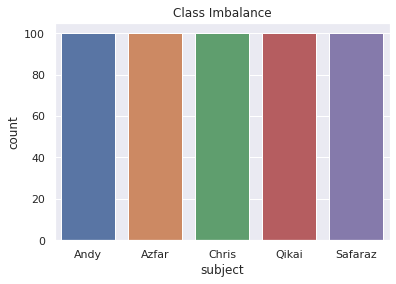

In [3]:
#################################
# # check for class imbalance # #
#################################

# sns.set_theme(style="darkgrid")
# ax = sns.countplot(x="subject", data=df).set_title("Class Imbalance")

# # remove missing values if available
# df = df.dropna()

# sns.catplot(x="subject", y="Dd.period", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [3]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to one hot encoded Y for model
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

#################################
# # get all the encoded class # #
#################################
print("Encoder is able to decipher: ")
print(encoder.get_feature_names_out())
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

Encoder is able to decipher: 
['x0_Andy' 'x0_Azfar' 'x0_Chris' 'x0_Qikai' 'x0_Safaraz']


X dataset shape: (500, 31)
Y dataset shape: (500, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Normalisation performed based on X_train
> * Reshaping of dataset for LSTM Timesteps

In [4]:
# split dataset into train and test of 0.8/0.2 ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)

# normalisation to 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
num_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (400, 1, 31)
Y train shape: (400, 5)
X test shape: (100, 1, 31)
Y test shape: (100, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [5]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, 
                 input_shape=(TIMESTEPS,NUM_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=100, 
                            batch_size=10)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable kfold validation

In [6]:
# from sklearn.model_selection import LeaveOneOut
# def evaluate_kfold(model, X_train, y_train, SEED):
    
#     # evaluate the model
#     model = create_model()
#     scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
#     ideal, _, _ = mean(scores), scores.min(), scores.max()
#     print('Ideal: %.3f' % ideal)
    
#     folds = range(2,31)
#     means, mins, maxs = list(), list(), list()
    
#     # evaluate each k value
#     for k in folds:
#         # define the test condition
#         kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
#         # evaluate k value
#         model = create_model()
#         scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
#         print(scores)
#         k_mean = np.mean(scores)
#         k_min = scores.min()
#         k_max = scores.max()
        
#         # report performance
#         print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
#               (k, k_mean*100, k_min*100, k_max*100))
        
#         # store mean accuracy
#         means.append(k_mean)
        
#         # store min and max relative to the mean
#         mins.append(k_mean - k_min)
#         maxs.append(k_max - k_mean)
        
#     # line plot of k mean values with min/max error bars
#     pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
#     # plot the ideal case in a separate color
#     pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
#     # show the plot
#     pyplot.show()
    
# evaluate_kfold(model, X_train, y_train, SEED)

In [7]:
# ##################################################
# # # evaluate kfold model for accuracy and loss # #
# ##################################################
# def evaluate_kfold_model(X_train, y_train, SEED):
#     scores, histories = list(), list()
#     # create model
#     model = create_model()
#     # prepare cross validation
#     kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
#     # enumerate splits
#     for train_ix, test_ix in kfold.split(X_train):
#         # select rows for train and test
#         trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
#         # fit model
#         history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_data=(testX, testY), verbose=0)
        
#         # evaluate model
#         y_pred = model.predict(testX)
#         y_pred = to_categorical(y_pred)

#         # evaluate predictions
#         acc = accuracy_score(testY, y_pred)
#         print("Testing accuracy: %.3f%%" % (acc*100))

#         # stores scores and histories
#         scores.append(acc)
#         histories.append(history)

#     for i in range(len(histories)):
#         # plot loss
#         f1 = plt.figure(1)
#         plt.title('Categorical Cross-Entropy Loss')
#         plt.plot(histories[i].history['loss'], color='blue')
#         plt.plot(histories[i].history['val_loss'], color='orange')
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')

#         # plot accuracy
#         f2 = plt.figure(2)
#         plt.title('Classification Accuracy')
#         plt.plot(histories[i].history['accuracy'], color='blue')
#         plt.plot(histories[i].history['val_accuracy'], color='orange')
#         plt.ylabel('accuracy')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='lower right')

#     # print summary
#     print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
#     # box and whisker plots of results
#     f3 = plt.figure(3)
#     plt.title('Box and Whisker Plot of Accuracy Scores')
#     plt.ylabel('accuracy')
#     plt.xlabel('model')
#     plt.boxplot(scores)
#     plt.show()
    
# evaluate_kfold_model(X_train, y_train, SEED)

##### Perform actual KFold Validation

In [8]:
# create model
model = create_model()

num_folds = 2
kfold = KFold(n_splits=num_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

Epoch 1/100
20/20 [==============================] - 8s 9ms/step - loss: 1.6240 - accuracy: 0.4000
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.5915 - accuracy: 0.7700
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.4784 - accuracy: 0.8100
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 0.3749 - accuracy: 0.8900
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.3524 - accuracy: 0.8900
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.3571 - accuracy: 0.8950
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.2841 - accuracy: 0.8950
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 0.3264 - accuracy: 0.9050
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 0.3199 - accuracy: 0.8800
Epoch 10/100
20/20 [==============================] - 0s 10ms/step - loss: 0.2656 - accuracy: 0.9000
E

##### Get Validation Accuracy

In [9]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

Validation Accuracy of 96.00% (with standard deviation of 0.50%)


### MODEL FITTING
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [10]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X_train, y_train, callbacks=es)

Epoch 1/100
40/40 [==============================] - 6s 11ms/step - loss: 1.1298 - accuracy: 0.5875
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 0.5162 - accuracy: 0.8125
Epoch 3/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3482 - accuracy: 0.8875
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.3047 - accuracy: 0.8850
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2826 - accuracy: 0.9175
Epoch 6/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2880 - accuracy: 0.8950
Epoch 7/100
40/40 [==============================] - 0s 10ms/step - loss: 0.2304 - accuracy: 0.9175
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.2422 - accuracy: 0.9200
Epoch 9/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2694 - accuracy: 0.9150
Epoch 10/100
40/40 [==============================] - 0s 10ms/step - loss: 0.2671 - accuracy: 0.9100

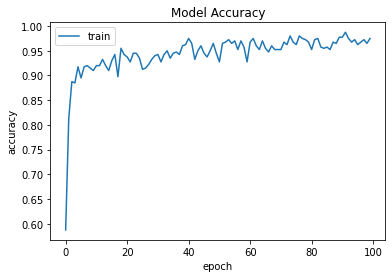

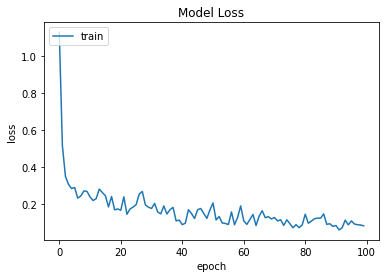

In [11]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [12]:
##########################
# # view model summary # #
##########################
model.model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 128)            81920     
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 1, 128)           512       
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_7 (Dropout)         (None, 1, 128)            0         
                                                                 
 batch_normalization_7 (Batc  (None, 1, 128)           512       
 hNormalization)                                      

### MODEL TESTING
> * get model accuracy on the test dataset
> * save the model if appropriate

In [13]:
y_pred = model.predict(X_test)
y_pred = to_categorical(y_pred)

# evaluate predictions
acc = accuracy_score(y_test, y_pred)
print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 98.000%


In [14]:
##################
# # save model # #
##################

model.model.save("model/key_classifier.h5")

###########################
# # save model in colab # #
###########################

# model.model.save(F"/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### ROC Curves (Individual Plot)

In [ ]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle


n_classes = 5
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
  plt.figure()
  lw = 2
  plt.plot(
      fpr[i],
      tpr[i],
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc[i],
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([-0.005, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic for class" + str(i))
  plt.legend(loc="lower right")
  plt.show()

### ROC Curves (Combined Plot)

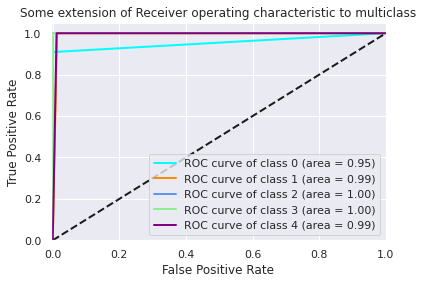

In [50]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### ROC Curve (Average out)

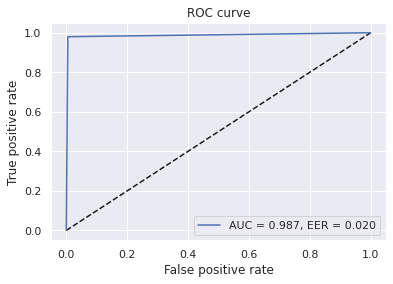

In [21]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

# Calculate equal-error-rate
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

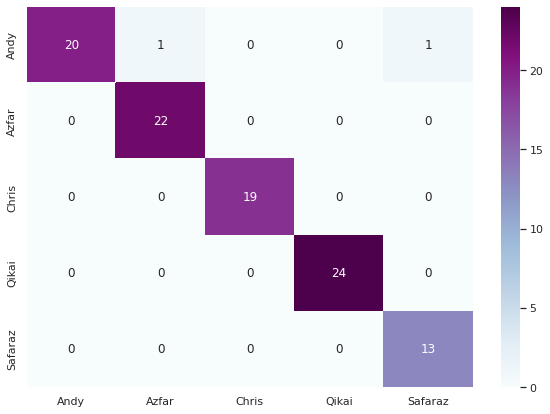

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


# Confusion Matrix
cm = confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred))
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(encoder.inverse_transform(y_test))], columns = [i for i in np.unique(encoder.inverse_transform(y_test))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")

### LOAD MODEL

In [ ]:
##################
# # load model # #
##################

model.model = load_model("model/key_classifier.h5")

###########################
# # load model in colab # #
###########################

# model.model = load_model("/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [24]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.174239,0.409866,0.235627,0.133840,0.171659,0.037820,0.156984,0.120599,-0.036385,0.111543,0.390015,0.278472,0.134937,0.264941,0.130004,0.144750,0.115824,-0.028925,0.120440,0.104092,-0.016348,0.137544,0.091721,-0.045824,0.099726,0.099142,-0.000585,0.120912,0.135934,0.015022,0.163508
1,Andy,1,2,0.145289,0.154851,0.009562,0.131217,0.129134,-0.002083,0.130980,0.092216,-0.038764,0.118131,0.191068,0.072937,0.164665,0.306797,0.142132,0.145192,0.127395,-0.017797,0.132026,0.117957,-0.014069,0.164865,0.111584,-0.053281,0.101935,0.023678,-0.078258,0.140863,0.192325,0.051462,0.156958
2,Andy,1,3,0.122266,0.136321,0.014055,0.114905,0.125308,0.010402,0.144332,0.098220,-0.046112,0.112351,0.198390,0.086040,0.121758,0.229243,0.107485,0.142623,0.143437,0.000814,0.120015,0.097180,-0.022835,0.145501,0.095982,-0.049520,0.121049,0.091486,-0.029563,0.111422,0.145751,0.034329,0.169304
3,Andy,1,4,0.121075,0.132562,0.011487,0.134813,0.132049,-0.002763,0.135681,0.079597,-0.056084,0.102607,0.203487,0.100880,0.117718,0.227770,0.110051,0.170992,0.183585,0.012593,0.120631,0.127893,0.007262,0.135072,0.089715,-0.045356,0.117885,0.089209,-0.028676,0.098095,0.139069,0.040974,0.168298
4,Andy,1,5,0.141361,0.124721,-0.016640,0.098268,0.149003,0.050735,0.128713,0.102436,-0.026277,0.101371,0.220777,0.119406,0.112454,0.242917,0.130463,0.144625,0.142355,-0.002269,0.120052,0.152262,0.032211,0.121480,0.078897,-0.042583,0.108607,0.049435,-0.059172,0.131348,0.156398,0.025050,0.170112


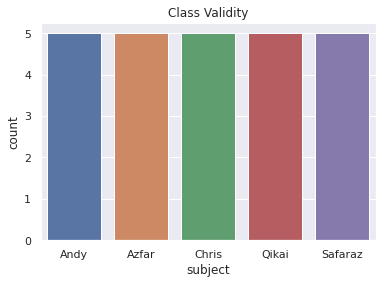

In [25]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
df = df.dropna()

In [26]:
pred_dataset = pred_df.values

# divide data into features X
# X_new = new_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

pred_row=pred_df.iloc[:,3:]

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[0:2,3:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_row.shape[0], TIMESTEPS, pred_arr.shape[1]))

In [31]:
####################################
# # get prediction and its label # #
####################################

pred = model.predict(pred_arr)
pred = to_categorical(pred)
pred = encoder.inverse_transform(pred)
pred = np.ravel(pred)

pred_proba = model.predict_proba(pred_arr)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
[['Andy']
 ['Andy']
 ['Andy']
 ['Andy']
 ['Andy']
 ['Azfar']
 ['Azfar']
 ['Azfar']
 ['Azfar']
 ['Azfar']
 ['Chris']
 ['Chris']
 ['Chris']
 ['Chris']
 ['Chris']
 ['Qikai']
 ['Qikai']
 ['Qikai']
 ['Qikai']
 ['Qikai']
 ['Safaraz']
 ['Safaraz']
 ['Safaraz']
 ['Safaraz']
 ['Safaraz']]
['Andy' 'Andy' 'Andy' 'Andy' 'Andy' 'Azfar' 'Azfar' 'Azfar' 'Azfar'
 'Azfar' 'Chris' 'Chris' 'Chris' 'Chris' 'Chris' 'Qikai' 'Qikai' 'Qikai'
 'Qikai' 'Qikai' 'Safaraz' 'Safaraz' 'Safaraz' 'Safaraz' 'Safaraz']
[[9.828